# Cuidado! Lluvia de Hamburguesas: 

## Análisis con KNN (K-Nearest Neighbors)


### Integrantes
* Primerano Lomba, Franco Alejandro
* Montecalvo, Ignacio

## K-Nearest Neighbors

A continuación realizaremos el analisis con KNN debido a que es un modelo con una logica bastante sencilla por detras pero que nos puede resultar de gran utilidad a la hora de querer hacer una clasificación.

Para utilizar este modelo no suele ser recomendable tener gran cantidad de features debido a que el proceso de entrenamiento puede volverse demasiado lento ante un dataset con dimensionalidad muy grande. Por lo tanto, vamos a considerar primero realizar una reducción de dimensionalidad.

Además, este modelo utiliza las distancias entre cada una de las instancias para determinar cuáles son vecinas entre sí. por lo tanto, va a funcionar mejor si previamente realizamos una normalizacion de nuestros datos de manera tal que los valores posibles de cada feature sean llevados a una misma escala. 

Los hiperparametros a definir son:

* n_neighbors: Es la cantidad de vecinos que se utilizará para hacer la predicción
* weights: Determina si todos los vecinos tienen la misma influencia (uniform) o si cada punto tiene un peso determinado por la inversa de la distancia (distance)

Aclaración: si bien no es un hiperparámetro del modelo en cuestión, también vamos a definir mediante iteraciones la cantidad de dimensiones a la que realizaremos la reducción. 

### Configuraciones iniciales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, auc, roc_curve, accuracy_score, recall_score, precision_score, f1_score

from preprocessing import aplicarOneHot
from preprocessing import aplicarPCA
from preprocessing import normalizar_entre_0_y_1, estandarizar, normalizar_segun_maximo_valor_absoluto

from auxiliares import obtener_training_set
from auxiliares import obtener_valdev_set
from auxiliares import obtener_prediccion_set
from auxiliares import plot_confusion_matrix
from auxiliares import plot_roc
from auxiliares import crear_archivo_predicciones


Primero cargamos los datos de entrenamiento (65% del dataset original) al cual ya le hicimos el tratamiento de missing values

In [2]:
x,y = obtener_training_set()

### Preprocesamiento

#### Manejo de Missing Values
El manejo de los Missing Values se realiza usando la misma lógica que en la primera parte del TP. De todas formas, ya importamos el dataset de entrenamiento con los missings solucionados

#### One Hot Encoding
Después, aplicamos One-hot encoding para las variables categóricas:

In [3]:
x = aplicarOneHot(x)

#### Reducción de dimensionalidad
Luego reducimos la dimensionalidad. Creemos que una buena opción sería probar con MDS o Isomap ya que buscan preservar las distancias (distancia geodesica en el segundo caso) y justamente lo que nos interesa con KNN son las distancias pero debido al tamaño del dataset no es posible ya que se requiere generar la matriz de distancias que posee mas de 100.000 filas y columnas,  y devuelve error. Por lo tanto, probaremos con PCA para distintas cantidades de dimensiones


El numero minimo de componentes para explicar el 95% de la varianza es: 7


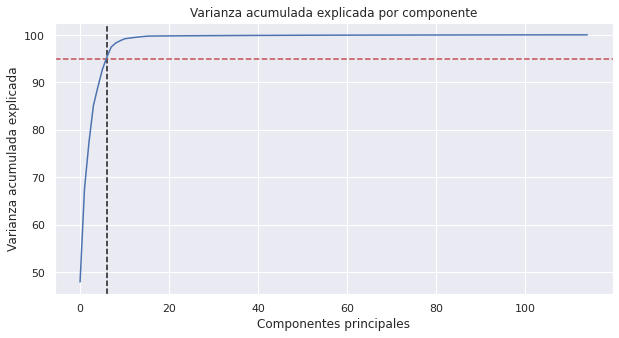

In [4]:
pca, componentes_principales = aplicarPCA(x,x)

var_acumulada = np.cumsum(pca.explained_variance_ratio_) * 100

# Cantidad minima de componentes que explican el 95% de varianza
k = np.argmax(var_acumulada > 95)
print("El numero minimo de componentes para explicar el 95% de la varianza es: " + str(k+1))

plt.figure(figsize=[10, 5])
plt.title('Varianza acumulada explicada por componente')
plt.ylabel('Varianza acumulada explicada')
plt.xlabel('Componentes principales')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_acumulada)

Vemos que para 7 componentes ya alcanzamos una varianza mayor al 95%. Antes de elegir definitivamente dicha cantidad de componentes vamos a visualizar una tabla con el porcentaje de varianza explicada para las dimensiones 1 a 10

In [5]:
pd.DataFrame(data=var_acumulada[:10], 
             index=np.arange(1,11,1), 
             columns=['% de Varianza explicada']).style.apply(
            lambda x: ['background: lightgreen' if (95< x['% de Varianza explicada'] < 96) else '' for i in x], axis=1)

,% de Varianza explicada
1,47.928051
2,67.558004
3,77.335566
4,85.093426
5,88.996584
6,92.668310
7,95.257347
8,97.440355
9,98.272494
10,98.755170


Efectivamente, tal como se veia en el grafico, a medida que aumentamos las dimensiones el porcentaje de varianza explicada sube rapidamente. Finalmente, decidimos seleccionar 7 componentes porque creemos que un 95% de varianza explicada es suficiente, y a su vez para cantidades mas pequeñas de componentes comienza a incrementarse notablemente la diferencia de porcentaje de varianza explicada respecto de la de 7 componentes (para 5 componentes ya perdimos un 6% y apenas tenemos dos componentes menos)

In [6]:
pca, componentes_principales = aplicarPCA(x, x, 7)

#### Normalización con valores entre 0 y 1

Una vez aplicada la reducción de dimensionalidad, procedemos a normalizar nuestros datos de manera tal que los valores posibles para cada uno de los features esté entre 0 y 1. Para ello usamos el MinMaxScaler.

In [7]:
x_normalizado = normalizar_entre_0_y_1(componentes_principales, componentes_principales)

#### Estandarización

Ahora probamos con aplicar otra forma de normalización, vamos a estandarizar los datos:

In [10]:
x_estandarizado = estandarizar(pd.DataFrame(data=componentes_principales.copy()),pd.DataFrame(data=componentes_principales).copy())

#### Normalización Maximo Valor Absoluto

Ahora probamos con aplicar otra forma de normalización, vamos a usar el Max Abs Scaler para escalar los datos:

In [13]:
x_normalizado_max_abs = normalizar_segun_maximo_valor_absoluto(componentes_principales,componentes_principales)

### Selección de Hiperparámetros

* Para seleccionar los mejores hiperparámetros vamos a usar Cross Validation con 5 folds estratificados. La evaluación se realizará usando como metrica el AUC ROC
* El algoritmo a usar será 'Ball Tree' debido a que al estar optimizado puede que el tiempo empleado a la predicción sea menor.
* La cantidad de vecinos que vamos a probar es: 10,20,40,60,80,100,150,200,500,1000,2000. Vamos hasta valores altos ya que tenemos gran cantidad de instancias.
* Para los pesos probamos 'uniform' y 'distance', para la última nos quedamos con la métrica por default que es la distancia euclideana (lo ideal seria probar con mas distancias pero esto tomaría demasiado tiempo)

#### Probamos con normalizar entre 0 y 1

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)
    
knn_clasificador = KNeighborsClassifier(algorithm='ball_tree')
gs_knn = GridSearchCV(knn_clasificador, {'n_neighbors':[10,20,40,60,80,100,150,200,500,1000,2000],'weights':['uniform','distance']}, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_knn.fit(x_normalizado, y.llovieron_hamburguesas_al_dia_siguiente)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=KNeighborsClassifier(algorithm='ball_tree'), n_jobs=-1,
             param_grid={'n_neighbors': [10, 20, 40, 60, 80, 100, 150, 200, 500,
                                         1000, 2000],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [9]:
resultados = pd.DataFrame(gs_knn.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_n_neighbors','param_weights','mean_test_score', 'std_test_score','mean_score_time']].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_n_neighbors,param_weights,mean_test_score,std_test_score,mean_score_time
15,1,200,distance,0.852581,0.003681,39.858481
13,2,150,distance,0.852369,0.003833,29.928460
14,3,200,uniform,0.851901,0.003764,41.874852
11,4,100,distance,0.851808,0.003771,15.393477
12,5,150,uniform,0.851742,0.003927,16.673959


#### Probamos con estandarizar

In [11]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)
    
knn_clasificador2 = KNeighborsClassifier(algorithm='ball_tree')
gs_knn2 = GridSearchCV(knn_clasificador2, {'n_neighbors':[10,20,40,60,80,100,150,200,500,1000,2000],'weights':['uniform','distance']}, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_knn2.fit(x_estandarizado, y.llovieron_hamburguesas_al_dia_siguiente)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=KNeighborsClassifier(algorithm='ball_tree'), n_jobs=-1,
             param_grid={'n_neighbors': [10, 20, 40, 60, 80, 100, 150, 200, 500,
                                         1000, 2000],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [12]:
resultados = pd.DataFrame(gs_knn2.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_n_neighbors','param_weights','mean_test_score', 'std_test_score','mean_score_time']].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_n_neighbors,param_weights,mean_test_score,std_test_score,mean_score_time
15,1,200,distance,0.853120,0.003850,60.433205
13,2,150,distance,0.852959,0.003961,56.440148
14,3,200,uniform,0.852361,0.003894,58.463425
12,4,150,uniform,0.852253,0.004043,56.278780
11,5,100,distance,0.852228,0.004192,53.093980


#### Probamos con normalizar según Máximo Absoluto

In [14]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)
    
knn_clasificador3 = KNeighborsClassifier(algorithm='ball_tree')
gs_knn3 = GridSearchCV(knn_clasificador3, {'n_neighbors':[10,20,40,60,80,100,150,200,500,1000,2000],'weights':['uniform','distance']}, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_knn3.fit(x_normalizado_max_abs, y.llovieron_hamburguesas_al_dia_siguiente)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=KNeighborsClassifier(algorithm='ball_tree'), n_jobs=-1,
             param_grid={'n_neighbors': [10, 20, 40, 60, 80, 100, 150, 200, 500,
                                         1000, 2000],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [15]:
resultados = pd.DataFrame(gs_knn3.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_n_neighbors','param_weights','mean_test_score','std_test_score','mean_score_time']].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_n_neighbors,param_weights,mean_test_score,std_test_score,mean_score_time
13,1,150,distance,0.850621,0.003871,38.512562
15,2,200,distance,0.850601,0.003641,40.871776
12,3,150,uniform,0.849965,0.003988,37.409313
14,4,200,uniform,0.849839,0.003741,40.961273
11,5,100,distance,0.849706,0.003696,32.353509


#### Resultados

Podemos observar que los scores que se obtienen son parecidos para las dos primeras formas de normalización, además los mejores hiperparámetros coinciden. Sin embargo, con la estandarización el score es levemente más alto así que nos quedamos con este preprocesamiento.

Entonces, concluimos en que los mejores hiperparámetros para KNN son:

In [16]:
print("Mejores hiperparámetros: \n\n\t* n_neighbors: ",gs_knn2.best_params_.get('n_neighbors'),"\n\t* weights: ",gs_knn2.best_params_.get('weights'))

Mejores hiperparámetros: 

	* n_neighbors:  200 
	* weights:  distance


### Entrenamiento y evaluación del modelo

Nos quedamos con el mejor estimador y lo fiteamos con todos los datos de entrenamiento:

In [17]:
knn_clasificador = gs_knn2.best_estimator_
knn_clasificador.fit(x_estandarizado, y.llovieron_hamburguesas_al_dia_siguiente)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=200, weights='distance')

Ahora cargamos el set de datos con el que vamos a evaluar:

In [18]:
x_val, y_val = obtener_valdev_set()

Aplicamos toda la lógica de preprocesamiento sobre estos datos de testing. Es importante destacar que sólo se utiliza información presente en el set de entrenamiento para realizar dicho preprocesamiento.  

In [19]:
# Relleno de missing values -> Dataset cargado con missing values ya tratados

# One Hot Encoding
x_val = aplicarOneHot(x_val)

# Aplicamos PCA (fiteado con los datos de entrenamiento)
pca_val, componentes_principales_val = aplicarPCA(x,x_val,7)

# Estandarizamos
x_val_estandarizado = estandarizar(pd.DataFrame(data=componentes_principales_val),pd.DataFrame(data=componentes_principales_val))

In [20]:
predicciones_proba = knn_clasificador.predict_proba(x_val_estandarizado)
predicciones = knn_clasificador.predict(x_val_estandarizado)

### Scores

#### AUC ROC



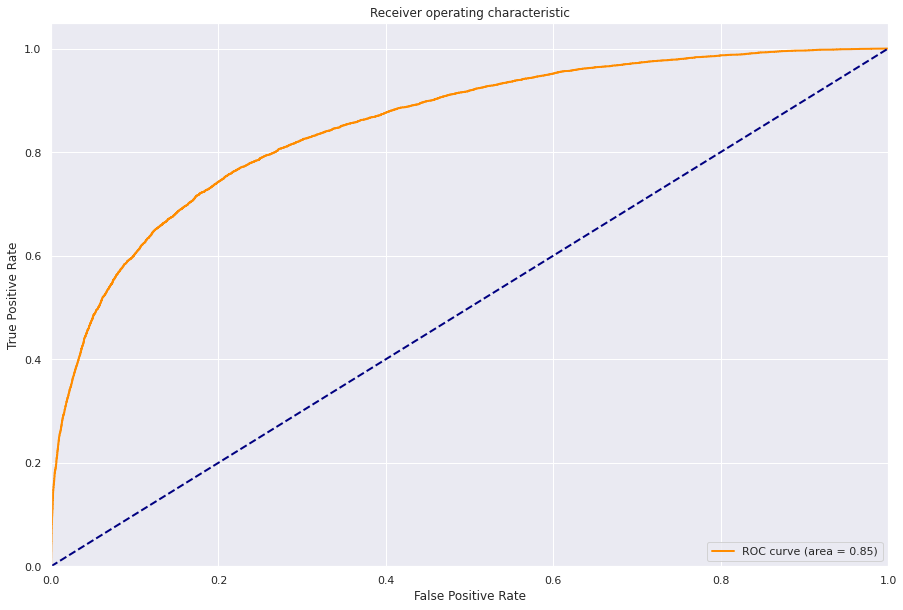

AUC ROC SCORE:  0.8530334983350567


In [27]:
fpr, tpr, thresholds = roc_curve(y_val, predicciones_proba[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
auc = roc_auc_score(y_val, predicciones_proba[:, 1])
print("AUC ROC SCORE: ",auc)

#### Matriz de confusión



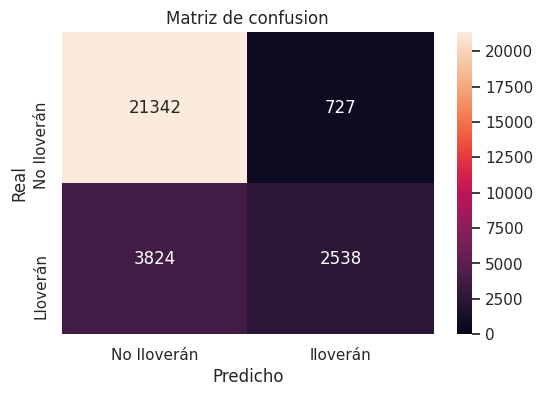

In [22]:
plot_confusion_matrix(y_val, predicciones)

#### Accuracy

In [28]:
accuracy =  accuracy_score(y_val,predicciones)
print("ACCURACY SCORE: ",accuracy)

ACCURACY SCORE:  0.8399282473356547


#### Precision y Recall 



In [24]:
precision = precision_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')
recall = recall_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')

print("PRECISION: ",precision,"\nRECALL: ",recall)

PRECISION:  0.7773353751914241 
RECALL:  0.3989311537252436


#### F1 Score

In [30]:
f1 = f1_score(y_val, predicciones, pos_label='si')
print("F1 SCORE: ", f1)

F1 SCORE:  0.527267061389841


In [32]:
pd.DataFrame(data=[auc, accuracy, precision,recall,f1],
             index= ['AUC ROC','Accuracy','Precision','Recall','F1 Score'],
             columns=['KNN Scores'])

,KNN Scores
AUC ROC,0.853033
Accuracy,0.839928
Precision,0.777335
Recall,0.398931
F1 Score,0.527267


#### Algunas observaciones

* El AUC ROC es bastante decente por tratarse de un modelo con una lógica bastante simple por detrás.

* Podemos observar que en la matriz de confusión destaca claramente los True Negative sobre el resto,  además el modelo tiende a predecir más Negative que Positive, lo cual se debe principalmente a la distribución que tienen los datos de entrenamiento.  

* El Accuracy también es medianamente decente, aunque probablemente no sea una métrica muy útil por sí sola dado a que el set no estaba balanceado, por lo que el simple hecho de predecir siempre 'no' ya nos hubiera dado un accuracy cercano al 0.80

* A su vez, la Precision obtenida es una de las mas altas en comparación con otros modelos, mientras que el Recall es bastante bajo debido a que nuestra Positive Label es 'si', y hay muchas menos instancias con target 'si' que con target 'no' por lo que hay menos True Positive y ante la presencia de fallos (especialmente False Negatives, los cuales superan a los True Positives), los scores disminuyen con mucha más facilidad. Esto lo podemos ver en las respectivas fórmulas:

$$
Precision=\frac{TP}{TP+FP} \ \ ; \ \ Recall=\frac{TP}{TP+FN}
$$

* En cuanto al F1 Score, este se calcula a partir del Recall y de la Precision, entonces como el Recall resultó ser basrante bajo, el F1 score resulta bajo también.

## Predicción sobre el nuevo dataset

Realizamos la predicción sobre el nuevo dataset utilizando el preprocesamiento aplicado anteriormente

In [36]:
nuevo_ds = obtener_prediccion_set()
ids_registro = np.array(nuevo_ds['id'])
nuevo_ds.drop('id', inplace=True, axis=1)

# One Hot Encoding
x_nuevo = aplicarOneHot(nuevo_ds)

# Aplicamos PCA (fiteado con los datos de entrenamiento)
pca, componentes_principales = aplicarPCA(x,x_nuevo,7)

# Normalizamos
x_nuevo_estandarizado = estandarizar(pd.DataFrame(data=componentes_principales.copy()),pd.DataFrame(data=componentes_principales.copy()))

predicciones = knn_clasificador.predict(x_nuevo_estandarizado)
crear_archivo_predicciones(predicciones,"KNN",ids_registro)